In [8]:
# ============================================================================
# DATA GENERATOR EXAMPLE
# ============================================================================
# This example demonstrates automatic generation of robust observed distributions
# from a causal DAG structure

import importlib
import sys

# Reload modules if already loaded
if 'symbolic_bounds' in sys.modules:
    import symbolic_bounds.dag
    import symbolic_bounds.joint_distribution
    import symbolic_bounds.scm
    import symbolic_bounds.linear_program
    import symbolic_bounds.program_factory
    
    importlib.reload(symbolic_bounds.dag)
    importlib.reload(symbolic_bounds.joint_distribution)
    importlib.reload(symbolic_bounds.scm)
    importlib.reload(symbolic_bounds.linear_program)
    importlib.reload(symbolic_bounds.program_factory)
    
    # Import and reload data_generator
    import symbolic_bounds.data_generator
    importlib.reload(symbolic_bounds.data_generator)
    
    import symbolic_bounds
    importlib.reload(symbolic_bounds)

from symbolic_bounds import DataGenerator, ProgramFactory, SCM
from symbolic_bounds.dag import DAG

print("=" * 80)
print("AUTOMATIC DATA GENERATION FROM DAG STRUCTURE")
print("=" * 80)

# Step 1: Create a DAG
print("\n1. Create DAG: X -> Y (both binary, both in W_R)")
print("-" * 80)

dag = DAG()
X = dag.add_node('X', support={0, 1}, partition='R')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(X, Y)

# Generate response types
dag.generate_all_response_types()

print(f"  Nodes: X, Y")
print(f"  X response types: {len(X.response_types)} (one per constant value)")
print(f"  Y response types: {len(Y.response_types)} (one per function X -> Y)")

# Step 2: Create DataGenerator
print("\n2. Initialize DataGenerator")
print("-" * 80)

generator = DataGenerator(dag, seed=42)
print("  ✓ Randomly sampled distribution over response types")

# Step 3: Display the true response type distribution
print("\n3. True Response Type Distribution P(R)")
print("-" * 80)

generator.print_true_distribution()

# Step 4: Compute observed joint distribution
print("\n4. Compute Observed Joint Distribution P(X, Y)")
print("-" * 80)
print("Using formula: P(X=x, Y=y) = Σ_{r: g(r)=(x,y)} P(R=r)")
print()

observed_joint = generator.computeObservedJoint()
observed_joint.print_distribution("Computed Observed Joint")

# Step 5: Create SCM and LP
print("\n5. Create SCM and Linear Program")
print("-" * 80)

scm = SCM(dag, observed_joint)
print("  ✓ SCM created and validated")

# Construct LP for P(Y=1 | do(X=1))
lp = ProgramFactory.write_LP(
    scm=scm,
    Y={Y},
    X={X},
    Y_values=(1,),
    X_values=(1,)
)
print("  ✓ LP constructed for query: P(Y=1 | do(X=1))")

# Step 6: Display LP summary
print("\n6. Linear Program Summary")
print("-" * 80)

summary = lp.get_summary()
print(f"  Decision variables: {summary['n_variables']}")
print(f"  Constraints: {summary['n_constraints']}")
print(f"  Objective non-zeros: {summary['objective_nonzero']}")

print("\n" + "=" * 80)
print("KEY INSIGHT")
print("=" * 80)
print("""
The DataGenerator ensures causal consistency:
1. Samples a distribution P(R) over response types
2. Each response type configuration r determines observable values v = g(r)
3. Observed distribution P(V) = Σ_{r: g(r)=v} P(R=r)

This guarantees that:
- The observed distribution respects the causal structure
- Interventional distributions can be computed consistently
- No compatibility issues arise between observational and interventional data
""")

AUTOMATIC DATA GENERATION FROM DAG STRUCTURE

1. Create DAG: X -> Y (both binary, both in W_R)
--------------------------------------------------------------------------------
  Nodes: X, Y
  X response types: 2 (one per constant value)
  Y response types: 4 (one per function X -> Y)

2. Initialize DataGenerator
--------------------------------------------------------------------------------
  ✓ Randomly sampled distribution over response types

3. True Response Type Distribution P(R)
--------------------------------------------------------------------------------

TRUE RESPONSE TYPE DISTRIBUTION

Node: X
----------------------------------------
  P(R_X = 0) = 0.134871
  P(R_X = 1) = 0.865129
  Total: 1.000000

Node: Y
----------------------------------------
  P(R_Y = [(X=0)→0, (X=1)→0]) = 0.512570
  P(R_Y = [(X=0)→0, (X=1)→1]) = 0.355381
  P(R_Y = [(X=0)→1, (X=1)→0]) = 0.066030
  P(R_Y = [(X=0)→1, (X=1)→1]) = 0.066019
  Total: 1.000000


4. Compute Observed Joint Distribution P(X, Y)

In [7]:
# ============================================================================
# DATA GENERATOR WITH CONFOUNDING
# ============================================================================
# Example with a confounder: Z -> X, Z -> Y (where Z is in W_L)

from symbolic_bounds import DataGenerator, ProgramFactory, SCM
from symbolic_bounds.dag import DAG

print("=" * 80)
print("DATA GENERATION WITH CONFOUNDING: Z -> X, Z -> Y")
print("=" * 80)

# Create DAG with confounder
dag_conf = DAG()
Z = dag_conf.add_node('Z', support={0, 1}, partition='L')  # Confounder
X = dag_conf.add_node('X', support={0, 1}, partition='R')
Y = dag_conf.add_node('Y', support={0, 1}, partition='R')

dag_conf.add_edge(Z, X)
dag_conf.add_edge(Z, Y)

dag_conf.generate_all_response_types()

print(f"\nDAG Structure:")
print(f"  W_L: {[n.name for n in dag_conf.W_L]}")
print(f"  W_R: {[n.name for n in dag_conf.W_R]}")
print(f"  Edges: Z -> X, Z -> Y")

print(f"\nResponse Types:")
print(f"  Z: {len(Z.response_types)} types")
print(f"  X: {len(X.response_types)} types (function of Z)")
print(f"  Y: {len(Y.response_types)} types (function of Z)")

# Generate data
print("\n" + "-" * 80)
generator_conf = DataGenerator(dag_conf, seed=123)
print("✓ Sampled response type distribution")

observed_joint_conf = generator_conf.computeObservedJoint()
print("✓ Computed observed joint P(Z, X, Y)")

observed_joint_conf.print_distribution("Observed Joint with Confounding")

# Create SCM and show it validates
scm_conf = SCM(dag_conf, observed_joint_conf)
print("\n✓ SCM validated - distribution is causally consistent")

print("\n" + "=" * 80)
print("VERIFICATION")
print("=" * 80)
print("""
The generated distribution P(Z, X, Y) is guaranteed to be compatible with:
1. Any interventional query (e.g., P(Y | do(X)))
2. The causal structure encoded in the DAG
3. The constraint system from Algorithm 1

This is because the distribution was generated from the structural equations:
  X = g_X(Z, R_X)
  Y = g_Y(Z, R_Y)
where R_X, R_Y are independent response types.
""")

DATA GENERATION WITH CONFOUNDING: Z -> X, Z -> Y

DAG Structure:
  W_L: ['Z']
  W_R: ['X', 'Y']
  Edges: Z -> X, Z -> Y

Response Types:
  Z: 2 types
  X: 4 types (function of Z)
  Y: 4 types (function of Z)

--------------------------------------------------------------------------------
✓ Sampled response type distribution
✓ Computed observed joint P(Z, X, Y)

Observed Joint with Confounding
  P(X=0, Y=0, Z=0) = 0.088318
  P(X=0, Y=0, Z=1) = 0.182216
  P(X=0, Y=1, Z=0) = 0.247600
  P(X=0, Y=1, Z=1) = 0.059484
  P(X=1, Y=0, Z=0) = 0.061140
  P(X=1, Y=0, Z=1) = 0.143115
  P(X=1, Y=1, Z=0) = 0.171406
  P(X=1, Y=1, Z=1) = 0.046720

Total probability: 1.000000

✓ SCM validated - distribution is causally consistent

VERIFICATION

The generated distribution P(Z, X, Y) is guaranteed to be compatible with:
1. Any interventional query (e.g., P(Y | do(X)))
2. The causal structure encoded in the DAG
3. The constraint system from Algorithm 1

This is because the distribution was generated from th

In [3]:
# ============================================================================
# FULL LINEAR PROGRAM EXAMPLE
# ============================================================================
# This example demonstrates the complete LP construction for computing
# bounds on causal effects P(Y=y | do(X=x))

# Reload modules to pick up latest changes
import importlib
import sys
if 'symbolic_bounds' in sys.modules:
    import symbolic_bounds
    importlib.reload(symbolic_bounds.dag)
    importlib.reload(symbolic_bounds.joint_distribution)
    importlib.reload(symbolic_bounds.scm)
    importlib.reload(symbolic_bounds.linear_program)
    importlib.reload(symbolic_bounds.program_factory)
    importlib.reload(symbolic_bounds)

from symbolic_bounds import ProgramFactory, JointDistribution, SCM
from symbolic_bounds.dag import DAG

print("=" * 80)
print("EXAMPLE: Full LP for Causal Effect Bounds")
print("=" * 80)

# Step 1: Create a DAG with causal structure X -> Y
# Both X and Y are in W_R (right partition)
print("\n1. Create DAG structure")
print("-" * 80)

dag = DAG()
X = dag.add_node('X', support={0, 1}, partition='R')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(X, Y)

dag.generate_all_response_types()
print(f"  Nodes: X, Y (both binary)")
print(f"  Edge: X -> Y")
print(f"  W_L: {[n.name for n in dag.W_L]}")
print(f"  W_R: {[n.name for n in dag.W_R]}")

# Step 2: Create observed joint distribution
# For this simple example, let's assume:
# P(X=0, Y=0) = 0.3, P(X=0, Y=1) = 0.2
# P(X=1, Y=0) = 0.1, P(X=1, Y=1) = 0.4
print("\n2. Create observed joint distribution")
print("-" * 80)

observed_joint = JointDistribution()
observed_joint.set_probability({(X, 0), (Y, 0)}, 0.3)
observed_joint.set_probability({(X, 0), (Y, 1)}, 0.2)
observed_joint.set_probability({(X, 1), (Y, 0)}, 0.1)
observed_joint.set_probability({(X, 1), (Y, 1)}, 0.4)

observed_joint.print_distribution()

# Step 3: Create SCM (validates that distribution covers all configurations)
print("\n3. Create Structural Causal Model (SCM)")
print("-" * 80)

scm = SCM(dag, observed_joint)
print("  ✓ SCM validated successfully")

# Step 4: Construct Linear Program for P(Y=1 | do(X=1))
print("\n4. Construct Linear Program for query: P(Y=1 | do(X=1))")
print("-" * 80)

lp = ProgramFactory.write_LP(
    scm=scm,
    Y={Y},           # Outcome node
    X={X},           # Intervention node
    Y_values=(1,),   # Target outcome: Y=1
    X_values=(1,)    # Intervention: X=1
)

print("  ✓ LP constructed successfully")

# Step 5: Display the Linear Program
print("\n5. Linear Program Structure")
print("=" * 80)

lp.print_lp(show_full_matrices=True)

# Step 6: Show LP summary
print("\n6. LP Summary")
print("=" * 80)

summary = lp.get_summary()
print(f"  Decision variables (q): {summary['n_variables']}")
print(f"  Equality constraints (P q = p): {summary['n_constraints']}")
print(f"  Objective non-zero entries: {summary['objective_nonzero']}")
print(f"  Constraint matrix non-zero: {summary['constraint_matrix_nonzero']}")
print(f"  RHS sum: {summary['rhs_sum']:.6f}")

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(f"""
The Linear Program computes bounds on P(Y=1 | do(X=1)):

minimize/maximize    α^T q
subject to           P q = p
                     q ≥ 0
                     1^T q = 1

Where:
- q: Decision variable of dimension {summary['n_variables']} (probabilities of response type combinations)
- α: Objective vector indicating which response types produce Y=1 when X=1
- P: Constraint matrix mapping response types to observed configurations
- p: Observed probabilities from data

The optimal value gives bounds on the causal effect P(Y=1 | do(X=1)).
Solving both minimization and maximization gives lower and upper bounds.
""")

EXAMPLE: Full LP for Causal Effect Bounds

1. Create DAG structure
--------------------------------------------------------------------------------
  Nodes: X, Y (both binary)
  Edge: X -> Y
  W_L: []
  W_R: ['X', 'Y']

2. Create observed joint distribution
--------------------------------------------------------------------------------

Joint Distribution
  P(X=0, Y=0) = 0.300000
  P(X=0, Y=1) = 0.200000
  P(X=1, Y=0) = 0.100000
  P(X=1, Y=1) = 0.400000

Total probability: 1.000000

3. Create Structural Causal Model (SCM)
--------------------------------------------------------------------------------
  ✓ SCM validated successfully

4. Construct Linear Program for query: P(Y=1 | do(X=1))
--------------------------------------------------------------------------------
  ✓ LP constructed successfully

5. Linear Program Structure

LINEAR PROGRAM

minimize    α^T q

Objective vector α:
  Dimension: 8
  Non-zero entries: 4 / 8

  α values:
    α[1] =   1.0000  (r_X^1, r_Y^2)
    α[3] =   1

In [ ]:
from symbolic_bounds import ProgramFactory
from symbolic_bounds.dag import DAG

# Test with simple DAG: X -> Y
print("="*80)
print("SIMPLE EXAMPLE: X -> Y")
print("="*80)

# Create a DAG
dag = DAG()

# Add binary nodes - all nodes must be assigned to a partition
X = dag.add_node('X', support={0, 1}, partition='L')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(X, Y)

dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)

constraints1 = ProgramFactory.write_constraints(dag)
constraints1.print_constraints(show_matrices=False, explicit_equations=True)

print("\n" + "="*80)
print("TESTING writeRung2: Constructing objective function for P(Y=1 | do(X=1))")
print("="*80)

# Note: For this simple DAG, X is in W_L and Y is in W_R
# So we cannot use writeRung2 directly as it requires both Y and X to be in W_R
# Let's create a different example where both are in W_R

print("\nCreating new DAG with X, Y both in W_R:")
dag2 = DAG()
X2 = dag2.add_node('X', support={0, 1}, partition='R')
Y2 = dag2.add_node('Y', support={0, 1}, partition='R')
dag2.add_edge(X2, Y2)
dag2.generate_all_response_types()

print("\nResponse types for X:")
dag2.print_response_type_table(X2)
print("\nResponse types for Y:")
dag2.print_response_type_table(Y2)

# First, get the constraints to see dimension of q
constraints2 = ProgramFactory.write_constraints(dag2)
print(f"\nDimension of decision variable q: ℵᴿ = {len(constraints2.response_type_labels)}")
print(f"Response type combinations r_γ for γ ∈ {{1, ..., {len(constraints2.response_type_labels)}}}:")
for i, label in enumerate(constraints2.response_type_labels):
    print(f"  γ={i}: {label}")

# Construct objective function for P(Y=1 | do(X=1))
print("\n" + "-"*80)
print("Query: P(Y=1 | do(X=1))")
print("-"*80)
alpha = ProgramFactory.writeRung2(dag2, {Y2}, {X2}, (1,), (1,))

print(f"\nObjective function vector α:")
print(f"  Dimension: {len(alpha)} (same as dim(q) = ℵᴿ = {len(constraints2.response_type_labels)})")
print(f"  ✓ Dimensions match: dim(α) = dim(q)")

print(f"\nα vector values:")
for i, val in enumerate(alpha):
    marker = "★" if val > 0 else " "
    print(f"  α[{i}] = {val:.0f}  {marker}  ({constraints2.response_type_labels[i]})")

print(f"\nInterpretation:")
print(f"  α^T q = P(Y=1 | do(X=1))")
print(f"  Non-zero entries ({sum(alpha > 0)} out of {len(alpha)}): response types that produce Y=1 when X=1")
print(f"  Under intervention do(X=1), we:")
print(f"    1. Override X to value 1 (ignore response type for X)")
print(f"    2. Use response types for Y to determine its value")
print(f"    3. Check if Y=1 results")


SIMPLE EXAMPLE: X -> Y

Response types for X (no parents):
r_X^1: X = 0
r_X^2: X = 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1

CONSTRAINT SYSTEM FROM ALGORITHM 1

                             Algorithm 1 Variables                              
--------------------------------------------------------------------------------
  ℵᴿ (aleph_R):      4  (number of response type combinations)
  B           :      4  (number of (W_L, W_R) configurations)
  dim(q)      :      4  (decision variable has 4 components)
  dim(p*)     :      4  (joint probability vector)
  |W_L configs|:      2  (number of distinct W_L configurations)
  dim(p|W_L)  :      2  (conditional prob. vector per W_L config)

                               Matrix Dimensions                                
--------------------------------------------------------------------------------
  P matrix    

In [52]:
print(constraints1.P)

[[1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DAG Summary:
  Total nodes: 5
  W_L nodes (2): L0, L1
  W_R nodes (3): R0, R1, R2
  Edges (5):
    L0 -> L1
    L0 -> R1
    L1 -> R0
    L1 -> R1
    R1 -> R2


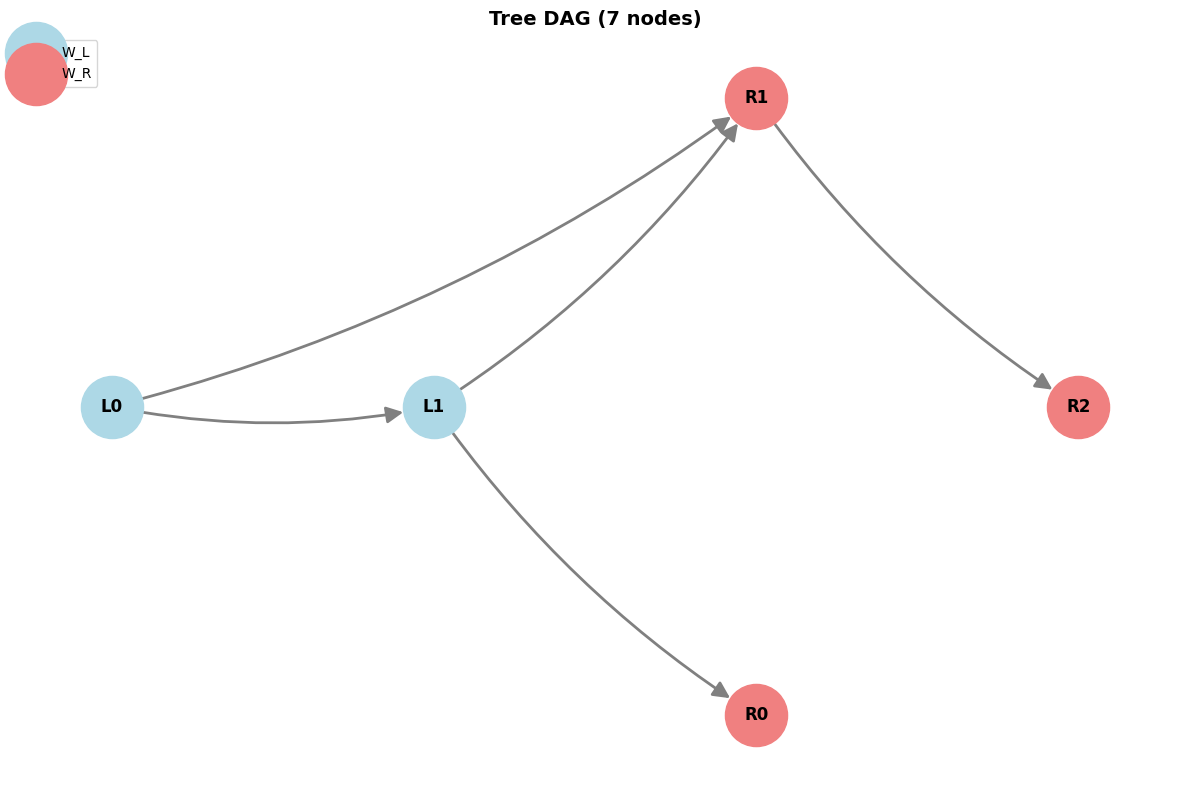

VALIDATING CONSTRAINTS FOR DAG
Nodes in W_L: L0, L1
Nodes in W_R: R0, R1, R2
Edges: L0->L1, L0->R1, L1->R0, L1->R1, R1->R2

GENERATED CONSTRAINTS
CONSTRAINT SYSTEM FROM ALGORITHM 1

                             Algorithm 1 Variables                              
--------------------------------------------------------------------------------
  ℵᴿ (aleph_R):    256  (number of response type combinations)
  B           :     32  (number of (W_L, W_R) configurations)
  dim(q)      :    256  (decision variable has 256 components)
  dim(p*)     :     32  (joint probability vector)
  |W_L configs|:      4  (number of distinct W_L configurations)
  dim(p|W_L)  :      8  (conditional prob. vector per W_L config)

                               Matrix Dimensions                                
--------------------------------------------------------------------------------
  P matrix    :   32 × 256   (Algorithm 1: P matrix)
  P* matrix   :   32 × 256   (Algorithm 1: P* matrix with p{W_L} weigh

True

In [153]:
from symbolic_bounds.dag import DAG
%load_ext autoreload
%autoreload 2
from symbolic_bounds.test_constraints import validate_constraints


from symbolic_bounds.random_dag_generator import (
    generate_random_partitioned_dag, 
    generate_random_chain_dag,
    generate_random_tree_dag,
    print_dag_summary
)
import matplotlib.pyplot as plt



tree_dag = generate_random_partitioned_dag(n=5)
print_dag_summary(tree_dag)
fig3 = tree_dag.draw(figsize=(12, 8), title="Tree DAG (7 nodes)")
plt.show()

validate_constraints(tree_dag, verbose=True)
